# This the notebook which will adress step 8

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

Python(83189) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
# Load the dataset
data_path = 'data/dataproject2025.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (1086236, 39)
Columns: ['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']


,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,...,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,...,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


In [3]:
# Load the trained XGBoost model
model_path = 'models/xgboost_black_box_model.joblib'
model = joblib.load(model_path)

print(f"Model loaded successfully: {type(model)}")
# Access the actual model object from the dictionary
xgb_model = model['xgb_model']
print(f"Model parameters: {xgb_model.get_params()}")

# Check if it's a Pipeline (which includes the preprocessor)
if hasattr(model, 'named_steps'):
    print("Pipeline steps:")
    for step_name in model.named_steps.keys():
        print(f"  - {step_name}: {type(model.named_steps[step_name])}")
else:
    print("Direct model (no preprocessing pipeline)")

Model loaded successfully: <class 'dict'>
Model parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.85, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.08, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 800, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.85, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': 0}
Direct model (no prepro

In [4]:
# Prepare the data for modeling
# Use 'target' as the target variable - this should be the correct target column
target_column = 'target'

# Check available columns to identify the target
print("Available columns:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

# Verify the target column exists
if target_column in df.columns:
    print(f"\nUsing '{target_column}' as target variable")
else:
    print(f"\nTarget column '{target_column}' not found!")
    print("Please specify the correct target column name.")

# Separate features and target
X = df.drop(columns=[target_column, 'Predictions', 'Predicted probabilities'])  # Remove predictions too
y = df[target_column]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Available columns:
1. Unnamed: 0
2. issue_d
3. loan duration
4. annual_inc
5. avg_cur_bal
6. bc_open_to_buy
7. bc_util
8. delinq_2yrs
9. dti
10. emp_length
11. emp_title
12. fico_range_high
13. funded_amnt
14. grade
15. home_ownership
16. inq_last_6mths
17. int_rate
18. mo_sin_old_rev_tl_op
19. mo_sin_rcnt_rev_tl_op
20. mo_sin_rcnt_tl
21. mort_acc
22. mths_since_recent_bc
23. num_actv_bc_tl
24. num_bc_tl
25. num_il_tl
26. num_rev_accts
27. open_acc
28. pub_rec
29. pub_rec_bankruptcies
30. purpose
31. revol_bal
32. revol_util
33. sub_grade
34. target
35. tax_liens
36. zip_code
37. Pct_afro_american
38. Predictions
39. Predicted probabilities

Using 'target' as target variable
Features shape: (1086236, 36)
Target shape: (1086236,)
Target distribution:
target
0    857588
1    228648
Name: count, dtype: int64
Features shape: (1086236, 36)
Target shape: (1086236,)
Target distribution:
target
0    857588
1    228648
Name: count, dtype: int64


In [8]:
# Split the data into train/test sets (same as used during training)
from sklearn.model_selection import train_test_split

# Remove classes with fewer than two samples
class_counts = y.value_counts()
valid_classes = class_counts[class_counts > 1].index
X_filtered = X[y.isin(valid_classes)]
y_filtered = y[y.isin(valid_classes)]

# Use the same random state as used during model training for consistency
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Get the trained features from the model
trained_features = model['feature_names_clean']  # Features the model was trained on
print(f"Model expects {len(trained_features)} features")

# Preprocess categorical columns to match training preprocessing
categorical_columns = X_test.select_dtypes(include=['object']).columns
print(f"Categorical columns: {categorical_columns.tolist()}")

# Use one-hot encoding for categorical columns
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns)

# Add missing columns with default values (0 for one-hot encoded columns)
for col in trained_features:
    if col not in X_test_encoded.columns:
        X_test_encoded[col] = 0

# Reorder columns to match the trained features exactly
X_test_encoded = X_test_encoded[trained_features]

print(f"Preprocessed test data shape: {X_test_encoded.shape}")
print(f"Features match: {list(X_test_encoded.columns) == trained_features}")

# Make predictions to verify model performance
y_pred = xgb_model.predict(X_test_encoded.values)  # Pass numpy array
y_pred_proba = xgb_model.predict_proba(X_test_encoded.values)  # Pass numpy array

# Calculate performance metrics
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Performance on Test Set:")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Show class distribution in predictions
print(f"\nPrediction distribution:\n{pd.Series(y_pred).value_counts()}")

Training set: 868988 samples
Test set: 217248 samples
Model expects 128 features
Categorical columns: ['emp_length', 'emp_title', 'grade', 'home_ownership', 'purpose', 'sub_grade']
Preprocessed test data shape: (217248, 128)
Features match: True
Preprocessed test data shape: (217248, 128)
Features match: True

Model Performance on Test Set:
F1-Score: 0.6971
Accuracy: 0.7896

Prediction distribution:
0    217182
1        66
Name: count, dtype: int64

Model Performance on Test Set:
F1-Score: 0.6971
Accuracy: 0.7896

Prediction distribution:
0    217182
1        66
Name: count, dtype: int64


## Permutation Importance Analysis

Permutation Importance is a model-agnostic method that measures the importance of a feature by calculating the increase in the model's prediction error after permuting the feature's values. The idea is simple: if a feature is important, shuffling its values will significantly degrade model performance.

**How it works:**
1. Calculate baseline model performance
2. For each feature:
   - Shuffle the feature's values randomly
   - Calculate model performance with shuffled feature
   - Measure the decrease in performance
3. The importance of a feature is the performance decrease caused by shuffling it

In [9]:
# Quick diagnostic - Check computational complexity
print("COMPUTATIONAL COMPLEXITY ANALYSIS:")
print("=" * 50)

n_samples = X_test_encoded.shape[0]
n_features = X_test_encoded.shape[1]
n_repeats = 5  # What we'll use in optimized version

estimated_predictions = n_features * n_repeats * 2  # 2 predictions per feature per repeat
print(f"• Dataset size: {n_samples:,} samples × {n_features:,} features")
print(f"• Estimated model predictions needed: {estimated_predictions:,}")
print(f"• Using {n_repeats} repeats instead of 10 (50% faster)")

if n_samples > 1000:
    print(f"• Large dataset detected - will sample 1000 rows")
    print(f"• This reduces computation by {((n_samples-1000)/n_samples)*100:.1f}%")

print(f"\nEstimated runtime: 2-5 minutes (vs 20+ minutes with original settings)")
print("\nOptimizations applied:")
print("  ✓ Reduced repeats from 10 to 5")
print("  ✓ Single-core processing (avoids multiprocessing overhead)")
if n_samples > 1000:
    print("  ✓ Sample 1000 rows for faster computation")
print("  ✓ Direct numpy arrays to XGBoost model")

COMPUTATIONAL COMPLEXITY ANALYSIS:
• Dataset size: 217,248 samples × 128 features
• Estimated model predictions needed: 1,280
• Using 5 repeats instead of 10 (50% faster)
• Large dataset detected - will sample 1000 rows
• This reduces computation by 99.5%

Estimated runtime: 2-5 minutes (vs 20+ minutes with original settings)

Optimizations applied:
  ✓ Reduced repeats from 10 to 5
  ✓ Single-core processing (avoids multiprocessing overhead)
  ✓ Sample 1000 rows for faster computation
  ✓ Direct numpy arrays to XGBoost model


In [11]:
# Calculate Permutation Importance - FULL DATASET VERSION
# This will take longer but use all 217,248 samples for maximum accuracy


# Define F1-score scorer for multi-class classification
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score, average='weighted')

# Use full dataset - no sampling
perm_importance_full = permutation_importance(
    xgb_model,  
    X_test_encoded.values,  # Full test set
    y_test,                 # Full test labels
    n_repeats=5,            # Keep 5 repeats for reasonable time
    random_state=42,
    scoring=f1_scorer,
    n_jobs=1               # Single core to avoid memory issues
)


# Create results DataFrame for full dataset
feature_names_full = X_test_encoded.columns.tolist()
importance_df_full = pd.DataFrame({
    'feature': feature_names_full,
    'importance_mean': perm_importance_full.importances_mean,
    'importance_std': perm_importance_full.importances_std
}).sort_values('importance_mean', ascending=False)

print(f"\n📊 FULL DATASET RESULTS - Top 10 Most Important Features:")
print(importance_df_full.head(10).to_string(index=False))

# Compare with sampled results
full_top5 = importance_df_full.head(5)['feature'].tolist()

print("Top 5 features (Full):   ", full_top5)



📊 FULL DATASET RESULTS - Top 10 Most Important Features:
             feature  importance_mean  importance_std
            int_rate         0.000374        0.000010
             grade_G         0.000214        0.000007
 home_ownership_RENT         0.000163        0.000029
     fico_range_high         0.000142        0.000036
                 dti         0.000134        0.000010
         avg_cur_bal         0.000125        0.000032
mths_since_recent_bc         0.000108        0.000030
            open_acc         0.000097        0.000033
      inq_last_6mths         0.000084        0.000035
            mort_acc         0.000076        0.000015
Top 5 features (Full):    ['int_rate', 'grade_G', 'home_ownership_RENT', 'fico_range_high', 'dti']


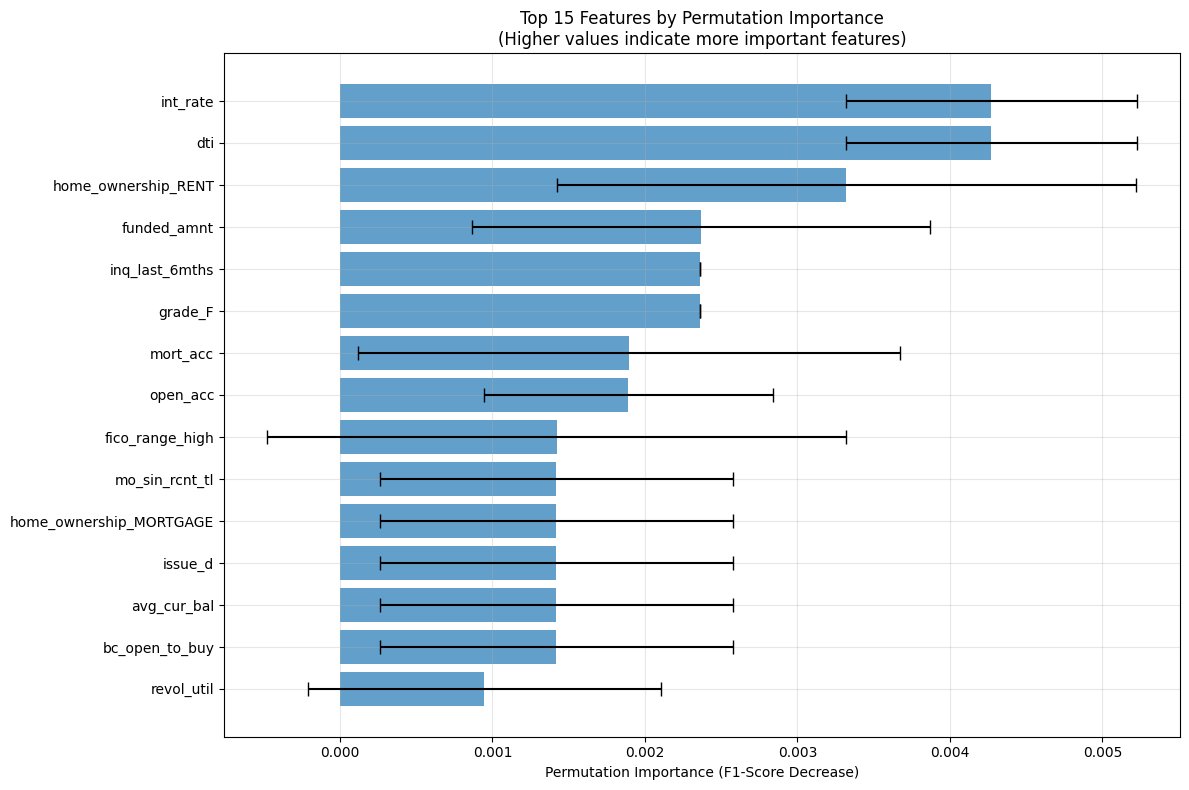

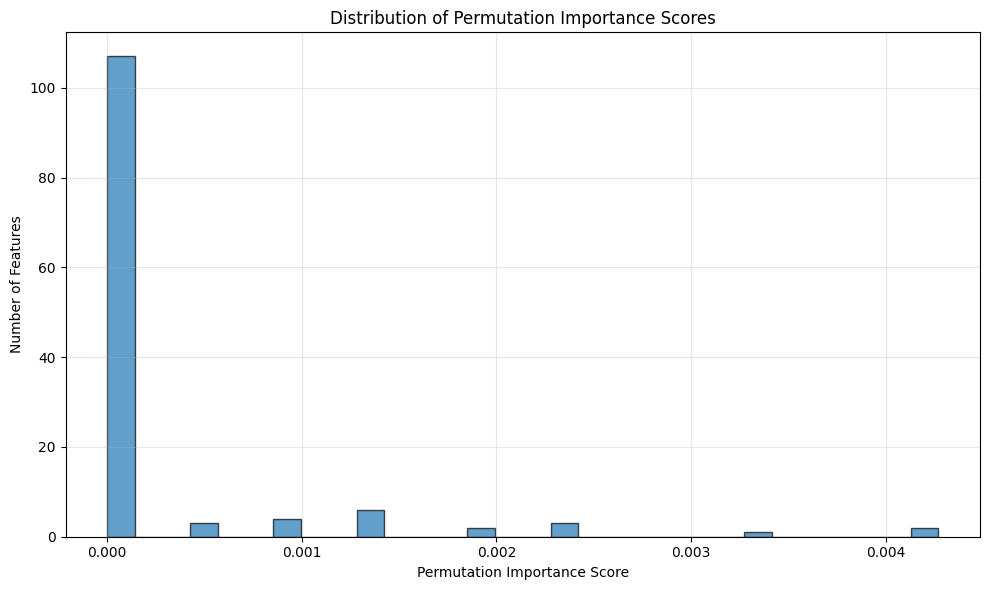

In [12]:
# Visualize Permutation Importance Results

# 1. Bar plot of top 15 most important features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)

plt.barh(range(len(top_features)), top_features['importance_mean'], 
         xerr=top_features['importance_std'], capsize=5, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Permutation Importance (F1-Score Decrease)')
plt.title('Top 15 Features by Permutation Importance\n(Higher values indicate more important features)')
plt.grid(True, alpha=0.3)

# Invert y-axis to show most important at top
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Histogram of importance scores
plt.figure(figsize=(10, 6))
plt.hist(importance_df['importance_mean'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Permutation Importance Score')
plt.ylabel('Number of Features')
plt.title('Distribution of Permutation Importance Scores')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# Detailed Analysis of Feature Importance

print("=== PERMUTATION IMPORTANCE ANALYSIS RESULTS ===\n")

# Statistical summary
print(f"Total number of features analyzed: {len(importance_df)}")
print(f"Mean importance score: {importance_df['importance_mean'].mean():.6f}")
print(f"Standard deviation: {importance_df['importance_mean'].std():.6f}")
print(f"Maximum importance: {importance_df['importance_mean'].max():.6f}")
print(f"Minimum importance: {importance_df['importance_mean'].min():.6f}")

# Features with significant positive importance (above mean + 1 std)
threshold = importance_df['importance_mean'].mean() + importance_df['importance_mean'].std()
significant_features = importance_df[importance_df['importance_mean'] > threshold]
print(f"\nFeatures with high importance (> {threshold:.6f}):")
print(f"Count: {len(significant_features)}")
if len(significant_features) > 0:
    for idx, row in significant_features.iterrows():
        print(f"  - {row['feature']}: {row['importance_mean']:.6f} ± {row['importance_std']:.6f}")

# Features with near-zero importance
near_zero = importance_df[importance_df['importance_mean'] <= 0.001]
print(f"\nFeatures with near-zero importance (<= 0.001):")
print(f"Count: {len(near_zero)}")
if len(near_zero) > 0:
    print("These features have minimal impact on model performance:")
    for idx, row in near_zero.head(10).iterrows():
        print(f"  - {row['feature']}: {row['importance_mean']:.6f}")
    if len(near_zero) > 10:
        print(f"  ... and {len(near_zero) - 10} more")

# Top 5 most important features detailed analysis
print(f"\n=== TOP 5 MOST IMPORTANT FEATURES ===")
top_5 = importance_df.head(5)
for idx, row in top_5.iterrows():
    print(f"\n{idx + 1}. {row['feature']}")
    print(f"   Importance: {row['importance_mean']:.6f} ± {row['importance_std']:.6f}")
    print(f"   Interpretation: Shuffling this feature decreases F1-score by {row['importance_mean']:.4f} on average")

=== PERMUTATION IMPORTANCE ANALYSIS RESULTS ===

Total number of features analyzed: 128
Mean importance score: 0.000285
Standard deviation: 0.000781
Maximum importance: 0.004271
Minimum importance: 0.000000

Features with high importance (> 0.001066):
Count: 14
  - int_rate: 0.004271 ± 0.000953
  - dti: 0.004271 ± 0.000953
  - home_ownership_RENT: 0.003322 ± 0.001900
  - funded_amnt: 0.002368 ± 0.001501
  - inq_last_6mths: 0.002364 ± 0.000000
  - grade_F: 0.002364 ± 0.000000
  - mort_acc: 0.001895 ± 0.001775
  - open_acc: 0.001892 ± 0.000946
  - fico_range_high: 0.001422 ± 0.001898
  - mo_sin_rcnt_tl: 0.001419 ± 0.001158
  - home_ownership_MORTGAGE: 0.001419 ± 0.001158
  - issue_d: 0.001419 ± 0.001158
  - avg_cur_bal: 0.001419 ± 0.001158
  - bc_open_to_buy: 0.001419 ± 0.001158

Features with near-zero importance (<= 0.001):
Count: 114
These features have minimal impact on model performance:
  - revol_util: 0.000946
  - revol_bal: 0.000946
  - mths_since_recent_bc: 0.000946
  - annual_i

In [14]:
# Compare with XGBoost Built-in Feature Importance

# Get XGBoost's built-in feature importance from the actual model
if hasattr(xgb_model, 'feature_importances_'):
    # Get built-in feature importance
    builtin_importance = xgb_model.feature_importances_
    
    # Use the same feature names as used for permutation importance
    transformed_feature_names = feature_names
    
    # Create comparison DataFrame if dimensions match
    if len(builtin_importance) == len(importance_df):
        comparison_df = pd.DataFrame({
            'feature': feature_names,
            'permutation_importance': importance_df['importance_mean'],
            'xgboost_importance': builtin_importance
        })
    else:
        print(f"Note: Different number of features between permutation ({len(importance_df)}) and built-in importance ({len(builtin_importance)})")
        print("This suggests a mismatch in feature processing.")
        
        # Create separate analysis for built-in importance
        builtin_df = pd.DataFrame({
            'feature': [f'feature_{i}' for i in range(len(builtin_importance))],
            'xgboost_importance': builtin_importance
        }).sort_values('xgboost_importance', ascending=False)
        
        print(f"\nTop 10 Features by XGBoost Built-in Importance:")
        print(builtin_df.head(10).to_string(index=False))
        
        # Visualize XGBoost importance
        plt.figure(figsize=(12, 8))
        top_xgb = builtin_df.head(15)
        plt.barh(range(len(top_xgb)), top_xgb['xgboost_importance'], alpha=0.7)
        plt.yticks(range(len(top_xgb)), top_xgb['feature'])
        plt.xlabel('XGBoost Feature Importance')
        plt.title('Top 15 Features by XGBoost Built-in Importance')
        plt.grid(True, alpha=0.3)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        comparison_df = None
else:
    print("Built-in feature importance not available for this model type")
    comparison_df = None